In [1]:
import math
import torch
import gpytorch
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Training data
train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

In [3]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        super(GPModel, self).__init__(x_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood)

In [4]:
train_iter = 50

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(train_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, train_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()
    

Iter 1/50 - Loss: 0.933   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.902   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.867   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.829   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.786   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.738   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.687   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.634   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.583   lengthscale: 0.372   noise: 0.369
Iter 10/50 - Loss: 0.537   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.495   lengthscale: 0.315   noise: 0.310
Iter 12/50 - Loss: 0.456   lengthscale: 0.291   noise: 0.284
Iter 13/50 - Loss: 0.419   lengthscale: 0.272   noise: 0.259
Iter 14/50 - Loss: 0.384   lengthscale: 0.255   noise: 0.236
Iter 15/50 - Loss: 0.349   lengthscale: 0.242   noise: 0.215
Iter 16/50 - Loss: 0.314   lengthscale: 0.232   noise: 0.196
Iter 17/50 - Loss: 0.280   length

In [8]:

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    model.eval()
    likelihood.eval()
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))
    f_preds = model(test_x)
    
    placeholder = f_preds.sample()
    
    for i in range(100):
        print(f_preds.sample().numpy())

[ 0.12140343  0.19510636  0.27060202  0.3512723   0.4369224   0.5261309
  0.6055063   0.68629885  0.7621291   0.8347019   0.8912225   0.9316646
  0.9702058   0.98376745  0.9825379   0.95507586  0.91874117  0.8547002
  0.77612144  0.68879086  0.57408905  0.45872754  0.32631642  0.19249082
  0.03942096 -0.09658301 -0.23488748 -0.37884426 -0.4963469  -0.6152661
 -0.7250607  -0.81827325 -0.89990836 -0.965584   -1.0068986  -1.0350319
 -1.0539151  -1.0529559  -1.0383071  -1.0073099  -0.9560901  -0.8969897
 -0.8237609  -0.74111736 -0.6497599  -0.55064327 -0.45507753 -0.35519496
 -0.2586196  -0.16722189 -0.09449221]
[ 0.0610228   0.16647775  0.26989266  0.38994458  0.50165564  0.60816497
  0.7117046   0.7989607   0.88660145  0.9530427   1.0005628   1.0433391
  1.0592613   1.0635817   1.0387954   1.0106059   0.9475965   0.8687552
  0.7845395   0.6831015   0.5677808   0.43805802  0.31346205  0.1754091
  0.04259656 -0.09546864 -0.22677653 -0.35183236 -0.4733858  -0.5849583
 -0.67406297 -0.7626365

/Users/jeewookim/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/jeewookim/.local/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


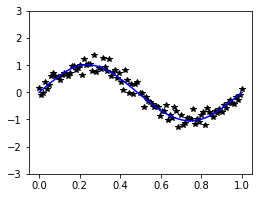

In [9]:
f_samples = f_preds.sample()

with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(4,3))
    
    lower, upper = observed_pred.confidence_region()
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.plot(test_x.numpy(), f_samples.numpy(), 'b')
    ax.set_ylim([-3, 3])

In [7]:
# Spectral Mixture Kernel

import math
import torch
import gpytorch
import matplotlib.pyplot as plt

%matplotlib inline

In [36]:
train_x = torch.linspace(0, 1, 15)
train_y = torch.sin(train_x * (2 * math.pi))

In [37]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGPModel(train_x, train_y, likelihood)

In [38]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 1.363
Iter 2/100 - Loss: 1.342
Iter 3/100 - Loss: 1.314
Iter 4/100 - Loss: 1.292
Iter 5/100 - Loss: 1.268
Iter 6/100 - Loss: 1.243
Iter 7/100 - Loss: 1.218
Iter 8/100 - Loss: 1.197
Iter 9/100 - Loss: 1.177
Iter 10/100 - Loss: 1.156
Iter 11/100 - Loss: 1.136
Iter 12/100 - Loss: 1.118
Iter 13/100 - Loss: 1.101
Iter 14/100 - Loss: 1.085
Iter 15/100 - Loss: 1.068
Iter 16/100 - Loss: 1.051
Iter 17/100 - Loss: 1.034
Iter 18/100 - Loss: 1.016
Iter 19/100 - Loss: 0.996
Iter 20/100 - Loss: 0.973
Iter 21/100 - Loss: 0.948
Iter 22/100 - Loss: 0.919
Iter 23/100 - Loss: 0.887
Iter 24/100 - Loss: 0.852
Iter 25/100 - Loss: 0.814
Iter 26/100 - Loss: 0.774
Iter 27/100 - Loss: 0.732
Iter 28/100 - Loss: 0.690
Iter 29/100 - Loss: 0.646
Iter 30/100 - Loss: 0.600
Iter 31/100 - Loss: 0.553
Iter 32/100 - Loss: 0.503
Iter 33/100 - Loss: 0.450
Iter 34/100 - Loss: 0.396
Iter 35/100 - Loss: 0.339
Iter 36/100 - Loss: 0.282
Iter 37/100 - Loss: 0.225
Iter 38/100 - Loss: 0.169
Iter 39/100 - Loss: 0

tensor([-0.0291,  0.5617,  0.9266,  0.9278,  0.5644, -0.0245, -0.6130, -0.9759,
        -0.9745, -0.6102, -0.0269,  0.5452,  0.8843,  0.8605,  0.4821, -0.1081,
        -0.6875, -1.0365, -1.0206, -0.6443, -0.0538,  0.5194,  0.8532,  0.8222,
         0.4398, -0.1496, -0.7253, -1.0680, -1.0436, -0.6608, -0.0712,  0.4916,
         0.8099,  0.7648,  0.3756, -0.2122, -0.7789, -1.1077, -1.0689, -0.6776,
        -0.0904,  0.4597,  0.7608,  0.7018,  0.3068, -0.2778, -0.8335, -1.1466,
        -1.0931, -0.6945, -0.1117])
tensor([ 0.0249,  0.6101,  0.9749,  0.9757,  0.6120,  0.0232, -0.5655, -0.9281,
        -0.9262, -0.5618,  0.0271,  0.6184,  0.9853,  0.9860,  0.6209,  0.0332,
        -0.5466, -0.8921, -0.8712, -0.4938,  0.0962,  0.6764,  1.0258,  1.0081,
         0.6295,  0.0396, -0.5286, -0.8545, -0.8161, -0.4299,  0.1589,  0.7302,
         1.0659,  1.0342,  0.6468,  0.0582, -0.4985, -0.8082, -0.7562, -0.3640,
         0.2224,  0.7838,  1.1051,  1.0590,  0.6639,  0.0787, -0.4644, -0.7567,
    

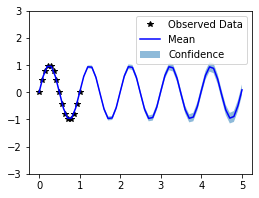

In [39]:
test_x = torch.linspace(0, 5, 51)

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    lower, upper = observed_pred.confidence_region()
    print(lower)
    print(upper)
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3,3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])